BioPAL

# BioPAL First AGB Tutorial

The BIOMASS Product Algorithm Laboratory (BioPAL) hosts official tools for processing and analysing ESA\'s BIOMASS mission data.

-   Website: www.biopal.org
-   Mailing: <biopal@esa.int>

_Disclamer:
this tutorial is experimental and may change without notice._ \
SPDX-FileCopyrightText: BioPAL <biopal@esa.int>\
SPDX-License-Identifier: MIT


## Tutorial Objective

In this tutorial, following topics will be discussed:
- requirements, biopal installation and environment preparation for this notebook to work
- setup and run of the Above Ground Biomass (AGB) processor (interactive notebook section)


## Requirements

- The installation procedure described here makes use of the open-source package management system [conda](https://docs.conda.io/projects/conda/en/latest/).
- Python >=3.6


## Installation and Jupyter Notebook Execution

1.  If you already created a biopal environment, than open a conda command window and go directly to step 3., otherwise download and unzip the current [BioPAL distribution](https://github.com/BioPAL/BioPAL) to your local hard drive.


2.  In a *conda* command window, enter in the directory where the BioPAL has been unzipped, and type the following instruction, which creates a biopal environment ( `environment.yml` is present into the main folder of BioPAL distribution ):
	
        conda env create --file environment.yml

3.  In the same *conda* command window, type the following instruction, which activates the created biopal environment:
	
        conda activate biopal

4.  In the same *conda* command window, install Jupyter notebook 
	
        conda install -c conda-forge jupyterlab

5.  In the same *conda* command window, open this Jupyter Notebook typing the following instructions:

        cd doc/Notebooks
        jupyter notebook
        

# Setup AGB Processor


## Main Ingredients

Main ingredients needed to run this tutorial:

-   `BioPAL/biopal/conf/Configuration_File.xml`: is the BioPAL configuration file (this tutorial is focused on the AGB only)

-   `BioPAL/inputs/Input_File.xml`: input file, to be set by the user before running an instance of the processing

This Notebook is supposed to be executed from `BioPAL/biopal/doc/Notebooks/BioPAL.ipynb`.

Setup of the AGB processor includes:
-   Input File check / preparation
-   Configuration File check / preparation


## BioPAL datasets

BioPAL gives easy access to several datasets that are used for examples in the documentation and testing. These datasets are hosted on the MAAP and must be downloaded for use. Contact <biopal@esa.int> to receive access to the dataset and for more information.
Each dataset is composed by two folders:
-   `dataSet`: folder containing L1 stacks of coregistered and calibrated SLC (Single Look Complex) data
-   `auxiliary_data_pf`: folder containing auxiliary products which are related to each particular dataSet 

Also a Lidar AGB - Reference map for validation, may be present. In this tutorial the AGB map used for validation is from [10.1109/JSTARS.2018.2851606](https://ieeexplore.ieee.org/document/8417912).

## Prepare Input

Open the `inputs/Input_File.xml` and focus on the following sections:

-   `L2_product`: specifies the algorithm to be run, here kept to `AGB` to enable the Above Ground Biomass processing (objective of this tutorial)
-   `output_specification` section: 
   * `output_folder`: full path of the folder where processing will save the products. Each run will generate a new sub-folder tagged with the processing time stamp (only in case of single run of the complete suite, see later section)
   * `geographic_grid_sampling`:value, in meters, of the sampling for the final processed product on geographic map, valid (east and north directions). Note: set this to 50m for this tutorial, for validation with the available Lidar AGB-Reference map
-   `dataset_query` section:
   * `L1C_repository`: should be put equal to the `dataSet` folder described above
   * `L1C_date`start and stop values to select L1 products, in UTC format
   * `auxiliary_products_folder`: should be put equal to the `auxiliary_data_pf` folder described above; in particular, the sub-folder ReferenceAGB, contains the reference data used to calibrate the AGB estimation inversion algorithm
   * `geographic_boundaries_polygon`: a set of 3 or more latitude-longitude points describing a polygon used to select L1 products

Note: the Input_File.xml in the repository is already filled with example values.


## Prepare Configuration

The BioPAL configuration file is `biopal/conf/Configuration_File.xml` and it is already filled with default AGB parameters to get valid estimation results; main parameters the users can modify are described hereafter, for more details refer to the complete documentation.

-   `ground_cancellation` section: 
   * `enhanced_forest_height`: forest height in meters used in the processing to determine the vertical wavenumber for which the ground cancelled data is generated (only with more than two acquisitions)  
-   `estimate_agb` section: 
   * `number_of_tests`: number of tests executed for AGB estimation following a random sampling scheme of estimation and calibration points (reference)
   * `fraction_of_roi_per_test`: percentage of estimation points randomly selected for each test   
   * `fraction_of_cal_per_test`: percentage of calibration points randomly selected for each test
   * `intermediate_ground_averaging`: ground cancelled averaging window size in meters on ground: it should be less or equal to product_resolution/2 (see below)
   * `product_resolution`: output product resolution (AGB) in meters on geographic map   
   * `distance_sampling_area`: estimation points distance in meters on geographic map
   * `estimation_valid_values_limits`: validity range of the output product in t/ha, invalid values will be masked out
   

# Run AGB Processor

There are two ways to run the AGB processor:
-   execution of the "main" in a single run
-   manual execution of each specific AGB step

In both cases, the first step is to add the `biopal` folder to the Python path.
In the following code, it is supposed to have this notebook in `BioPAL/biopal/doc/Notebooks/BioPAL.ipynb`
If this is not the case, you can manually set the `biopal_path` in the following example:

In [3]:
from pathlib import Path
import sys
import os
import warnings
warnings.filterwarnings('ignore') # warnings silenced for convenience

# First try an import to verify if the python path alread contains biopal, otherwise do the import
try:
    from biopal.__main__ import biomassL2_processor_run
    print('The BioPAL is already into the python path')
except:
        
    # get the biopal folder path, supposing that we are in the working directory "biopal/doc/Notebooks/"
    notebook_working_dir = Path.cwd()
    biopal_path = notebook_working_dir.parent.parent
    sys.path.append( str(biopal_path) )

    # Try an import to verify the python path
    try:
        from biopal.__main__ import biomassL2_processor_run

        print('The BioPAL path "{}" has been succesfully added to the python path'.format(biopal_path))

    except Exception:
        raise Exception( 'The BioPAL Notebook needs to be executed from the folder "BioPAL/doc/Notebooks" and the "biopal" environment should be enabled too. It has been executed from "{}" instead.'.format(notebook_working_dir) )

The BioPAL path "C:\ARESYS_PROJ\BioPAL" has been succesfully added to the python path


# Run AGB Processor by execution of each AGB step

The AGB processor can be executed by manual run of each AGB step (APPs): each APP computes the inputs needed by the following one, and updates the input file adding each APP specific section, and (when needed) also the configuration file.

### dataset_query APP run

The first APP to be executed, the `dataset_query`, is in charge of getting from the `L1C_repository` only the stacks matching the specified temporal and geographical region of interest. 

It takes as input the `inputs\Input_File.xml` path, prepared in the above steps of this tutorial.

The input file will be updated adding the new section `stack_based_processing` needed to the following APP.
The updated input file will be saved into the output folder.

In [4]:
input_path = str( Path.home().joinpath( biopal_path, "inputs", "Input_File.xml") ) 
from biopal.dataset_query.dataset_query import dataset_query

# Initialize dataset query APP (no configuration file needed in this case)
dataset_query_obj = dataset_query()

# Run dataset query APP
print('Query started...')
input_path_from_query, _, _  = dataset_query_obj.run( input_path )

print('The Input_File has been updated with the new section "stack_based_processing" and saved to {}'.format(input_path_from_query))

Query started...
Query completed.
The Input_File has been updated with the new section "stack_based_processing" and saved to C:\bio\testTutorialOut\InputFile_StackBasedProcessingAGB.xml


Hereafter we check the new `stack_based_processing` section added to the input file: as an example we print all the SLC SAR images acquisition IDs selected by the query and the path of the DTM projected in radar coordinates.

In [5]:
    from biopal.io.xml_io import parse_input_file

    # read the updated input file:
    input_params_obj = parse_input_file(input_path_from_query)
    
    # get the new section stack_based_processing:
    stack_based_processing_obj = input_params_obj.stack_based_processing
    
    # read the IDs of the stacks found from the query:
    found_stack_ids = stack_based_processing_obj.stack_composition.keys()
    print('SLC SAR images (slant range geometry) stacks and acquisitions found from the query')
    for stack_id, acquisition_ids in stack_based_processing_obj.stack_composition.items():
        print('\n    Stack:')
        print('    ', stack_id)
        print('        Acquisitions:')
        for acq_id in acquisition_ids:
            print('        ', acq_id)
    dataSet_path = input_params_obj.dataset_query.L1C_repository
    print('\n The above stacks with the acquisitions can be found at following path:\n {}'.format( dataSet_path ))
    
    # Print the path of the DTM projected in radar coordinates
    reference_height_path = Path.home().joinpath(
        dataSet_path,
        stack_based_processing_obj.reference_height_file_names[stack_id]
        )
    print('\n Full path of the reference height file valid for the above stack {}: \n {}'.format(stack_id, reference_height_path))                                                            

SLC SAR images (slant range geometry) stacks and acquisitions found from the query

    Stack:
     GC_03_H_320.00_RGSW_00_RGSBSW_00_AZSW_00
        Acquisitions:
         GC_03_H_320.00_RGSW_00_RGSBSW_00_AZSW_00_BSL_07
         GC_03_H_320.00_RGSW_00_RGSBSW_00_AZSW_00_BSL_08
         GC_03_H_320.00_RGSW_00_RGSBSW_00_AZSW_00_BSL_09

 The above stacks with the acquisitions can be found at following path:
 C:\bio\testTutorialData\demo_tomoSAR\dataSet

 Full path of the reference height file valid for the above stack GC_03_H_320.00_RGSW_00_RGSBSW_00_AZSW_00: 
 C:\bio\testTutorialData\demo_tomoSAR\auxiliary_data_pf\Geometry\ReferenceHeight\GC_03_H_320.00_RGSW_00_RGSBSW_00_AZSW_00


Level 1 data


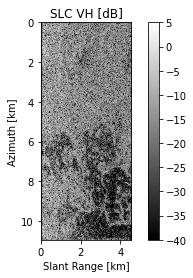

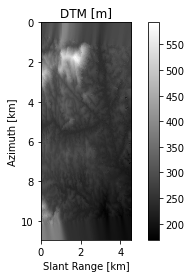

In [6]:
# plots
from arepytools.io.productfolder import ProductFolder
import numpy as np
from matplotlib import pyplot as plt

# Plotting one of the SLC
slc_pf_path = Path.home().joinpath( dataSet_path, acq_id)
pf = ProductFolder( slc_pf_path,'r' )
channel_to_read = 2 # Counter is zero based, 2 is VH
SLC = pf.read_data( channel_to_read )
SLC_db = 10*np.log10( np.abs(SLC)**2 )
# for the axis
data_channel_obj = pf.get_channel( channel_to_read )
metadata_obj = data_channel_obj.metadata
metadatachannel_obj = metadata_obj.get_metadata_channels(0)
ri = metadatachannel_obj.get_element("RasterInfo")
range_length_km = ri.samples*ri.samples_step/1000
azimuth_length_km = ri.lines*ri.lines_step /1000 
# plot 
plt.figure(1)
plt.imshow( SLC_db, interpolation='none', origin='upper', cmap='gray',
            extent=[ 0, range_length_km, azimuth_length_km, 0])
plt.colorbar()
plt.xlabel('Slant Range [km]')
plt.ylabel('Azimuth [km]')
plt.clim([-40,5])
plt.title('SLC VH [dB]')

# Plotting the reference height
pf = ProductFolder( reference_height_path,'r' )
channel_to_read = 0 # Counter is zero based, there is only one channel
ref_height = pf.read_data( channel_to_read )
# for the axis
data_channel_obj = pf.get_channel( channel_to_read )
metadata_obj = data_channel_obj.metadata
metadatachannel_obj = metadata_obj.get_metadata_channels(0)
ri = metadatachannel_obj.get_element("RasterInfo")
range_length_km = ri.samples*ri.samples_step/1000
azimuth_length_km = ri.lines*ri.lines_step /1000 
# plot         
plt.figure(2)
plt.imshow( ref_height, interpolation='none', origin='upper', cmap='gray',
            extent=[ 0, range_length_km, azimuth_length_km, 0] )
plt.colorbar()
plt.xlabel('Slant Range [km]')
plt.ylabel('Azimuth [km]')
plt.title('DTM [m]')
print('Level 1 data')

### StackBasedProcessingAGB APP run

The second APP to be executed, is the `StackBasedProcessingAGB`, which takes the above stacks and preprocesses them with ground cancellation and geocoding.

It takes as input:
-   the Input File path, the one prepared by the `dataset_query` APP, containing the new `stack_based_processing` section
-   the Configuration File path

The input file will be updated in the end adding the new section `core_processing_agb`for the following APP.
The configuration file is updated too.
The updated input file and configuration file will be saved into output folder.

In [7]:
from biopal.agb.main_AGB import StackBasedProcessingAGB
configuration_file_path = str( Path.home().joinpath( biopal_path, "biopal", "conf", "Configuration_File.xml" ) )

# Initialize Stack Based Processing AGB APP
stack_based_processing_obj = StackBasedProcessingAGB( configuration_file_path )

# Run Stack Based Processing AGB APP
print('AGB stack-based processing APP started...')
input_file_from_stack_based, configuration_file_updated = stack_based_processing_obj.run( input_path_from_query )
    
    
print('The Input_File has been updated with the new section "core_processing_agb" and saved to {}'.format(input_file_from_stack_based))

AGB stack-based processing APP started...
AGB stack-based processing APP ended correctly.

The Input_File has been updated with the new section "core_processing_agb" and saved to C:\bio\testTutorialOut\Input_File_CoreProcessingAGB.xml


Hereafter we print the paths of some of the computed data, all stored in the output folder.

In [8]:
# Some of the computed output paths:
import os
input_params_obj = parse_input_file(input_file_from_stack_based)
output_folder = input_params_obj.output_specification.output_folder

npy_name = str(list(Path( Path.home().joinpath(output_folder, 'Products', 'breakpoints') ).rglob('*.npy'))[0])
ground_canc_sr_path = Path.home().joinpath( 
    output_folder, 
    npy_name,
    )
print('\n Path of ground cancelled data in slant range geometry: \n {}'.format(ground_canc_sr_path))

geocoded_dir = str(list(Path( Path.home().joinpath(output_folder, 'Products', 'temp', 'geocoded')  ).rglob('GC_*'))[0])
sigma_tif_name = str(list(Path( geocoded_dir ).rglob('sigma0_vh.tif'))[0])
ground_canc_gr_path = Path.home().joinpath( 
    geocoded_dir, 
    sigma_tif_name,
)
print('\n  Path of ground cancelled VH data, geocoded: \n {}'.format(ground_canc_gr_path))

theta_tif_name = str(list(Path( geocoded_dir ).rglob('theta.tif'))[0])
theta_inc_path = Path.home().joinpath( 
    geocoded_dir, 
    theta_tif_name,
)
print('\n  Path of incidence angle map, geocoded: \n {}'.format(theta_inc_path))



 Path of ground cancelled data in slant range geometry: 
 C:\bio\testTutorialOut\AGB\Products\breakpoints\ground_cancelled_SR_GC_03_H_320.00_RGSW_00_RGSBSW_00_AZSW_00.npy

  Path of ground cancelled VH data, geocoded: 
 C:\bio\testTutorialOut\AGB\Products\temp\geocoded\GC_03_H_320.00_RGSW_00_RGSBSW_00_AZSW_00\sigma0_vh.tif

  Path of incidence angle map, geocoded: 
 C:\bio\testTutorialOut\AGB\Products\temp\geocoded\GC_03_H_320.00_RGSW_00_RGSBSW_00_AZSW_00\theta.tif


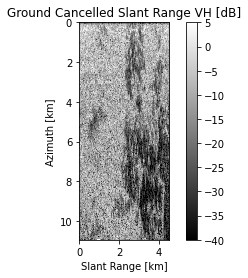

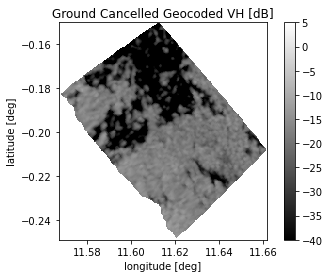

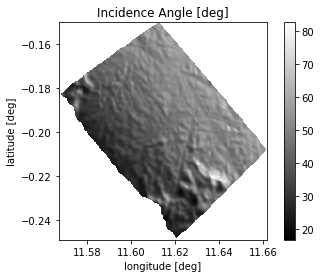

In [42]:
# plots
import numpy as np
from osgeo import gdal
from gdalconst import GA_ReadOnly

# ground cancelled slant range
GC_SR_VH = np.load( str(ground_canc_sr_path), allow_pickle=True).item(0)['vh']
GC_SR_VH_db = 10*np.log10( np.abs( GC_SR_VH )**2 )
# for the axis
azimuth_pixel_spacing = 3.63676 # got from xml
slant_range_pixel_spacing = 11.988876 # got from xml
samples, lines = GC_SR_VH_db.shape
range_length_km = samples*slant_range_pixel_spacing/1000
azimuth_length_km = lines*azimuth_pixel_spacing /1000 
# Plot     
plt.figure(3)
plt.imshow( GC_SR_VH_db, interpolation='none', origin='upper', cmap='gray',
            extent=[ 0, range_length_km, azimuth_length_km, 0] )
plt.colorbar()
plt.clim([-40,5])
plt.xlabel('Slant Range [km]')
plt.ylabel('Azimuth [km]')
plt.title('Ground Cancelled Slant Range VH [dB]')

# ground cancelled geocoded
data_driver = gdal.Open( str(ground_canc_gr_path), GA_ReadOnly)
GC_GR_VH = data_driver.GetRasterBand(1).ReadAsArray()
GC_GR_VH_db = 10*np.log10( np.abs( GC_GR_VH )**2 )
# for the axis
geotransform = data_driver.GetGeoTransform()
lat_deg_ax = geotransform[0] + geotransform[1] * np.arange(data_driver.RasterXSize)
lon_deg_ax = geotransform[3] + geotransform[5] * np.arange(data_driver.RasterYSize)
# plot
plt.figure(4);
plt.imshow( GC_GR_VH_db, interpolation='none', cmap='gray', origin='upper',
            extent=[ lat_deg_ax[0], lat_deg_ax[-1], lon_deg_ax[-1], lon_deg_ax[0] ])
plt.colorbar()
plt.clim([-40,5])
plt.title('Ground Cancelled Geocoded VH [dB]')
plt.xlabel('longitude [deg]')
plt.ylabel('latitude [deg]')
data_driver = None

# Incidence angle map
data_driver = gdal.Open( str(theta_inc_path), GA_ReadOnly)
theta_inc_deg = np.rad2deg( data_driver.GetRasterBand(1).ReadAsArray() )
# for the axis
geotransform = data_driver.GetGeoTransform()
lat_deg_ax = geotransform[0] + geotransform[1] * np.arange(data_driver.RasterXSize)
lon_deg_ax = geotransform[3] + geotransform[5] * np.arange(data_driver.RasterYSize)
# plot
plt.figure(5);
plt.imshow( theta_inc_deg, interpolation='none', cmap='gray', origin='upper',
            extent=[ lat_deg_ax[0], lat_deg_ax[-1], lon_deg_ax[-1], lon_deg_ax[0] ])
plt.colorbar()
plt.title('Incidence Angle [deg]')
plt.xlabel('longitude [deg]')
plt.ylabel('latitude [deg]')
data_driver = None

### CoreProcessingAGB APP run

The third and last APP to be executed is `CoreProcessingAGB`, which is in charge of performing the AGB estimation.

It takes as input:
-   the Input File path, the one prepared by the `stack_based_processing` APP, containingh the new `core_processing_agb` section
-   the Configuration File path, the one updated by the `stack_based_processing` APP

In [6]:
from biopal.agb.main_AGB import CoreProcessingAGB

# Initialize Core Processing AGB APP
agb_processing_obj = CoreProcessingAGB( configuration_file_updated )
    
# Run Main APP #2: AGB Core Processing
print('AGB core-processing APP started (this will take some time, wait for ending message)...')
agb_processing_obj.run(input_file_from_stack_based)

AGB core-processing APP started (this will take some time, wait for ending message)...


AGB core-processing APP ended correctly.



Hereafter we print the paths of the final product and the calibration product used in the algorithm.
Products are geocoded to [EQUI7 map](https://github.com/TUW-GEO/Equi7Grid) 

In [10]:
# Final products full paths:
input_params_obj = parse_input_file(input_file_from_stack_based)
output_folder = input_params_obj.output_specification.output_folder
tile_equi7_folder = list(Path.home().joinpath( Path(output_folder),  'Products','global_AGB').rglob('*'))[0]
tile_equi7_subfolder = list(Path(tile_equi7_folder).rglob('*'))[0]
final_estimation_path = list(Path(tile_equi7_subfolder).rglob('*.tif'))[0]
print('\n Path of the final AGB estimation product, in EQUI7 map geometry: \n {}'.format(final_estimation_path))
    
reference_agb_folder = input_params_obj.stack_based_processing.reference_agb_folder
calibration_path = Path.home().joinpath( 
    reference_agb_folder, 'cal_05_no_errors.tif')
print('\n Path of the input calibration data used: \n {}'.format(calibration_path))
    


 Path of the final AGB estimation product, in EQUI7 map geometry: 
 C:\bio\testTutorialOut\AGB\Products\global_AGB\AF050M\E045N048T3\agb_1_est_db_backtransf_.tif

 Path of the input calibration data used: 
 C:\bio\testTutorialData\demo_tomoSAR\auxiliary_data_pf\ReferenceAGB\cal_05_no_errors.tif


Processing results


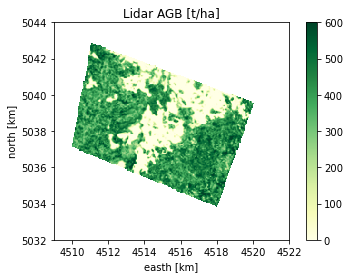

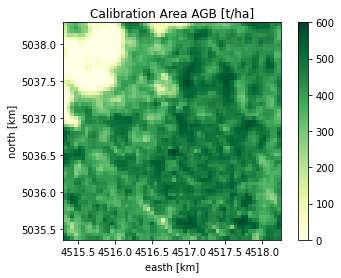

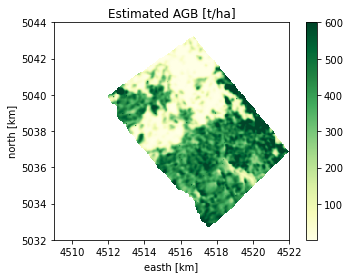

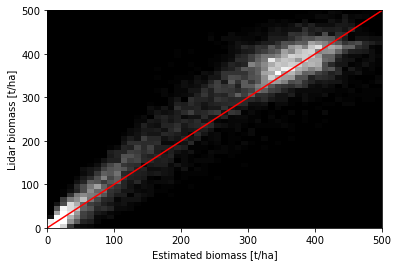

In [15]:
# plots
import numpy as np
from pathlib import Path
from matplotlib import pyplot as plt
from scipy.signal import convolve
from osgeo import gdal
from gdalconst import GA_ReadOnly

# pyplot axis limits (east and north, km, for the equi7 tile)
xlims = [4509, 4522] # east
ylims = [5032, 5044] # north

# lidar AGB - Reference map for validation (set your path)
lidar_agb_path = r"your_path_here\lope_lidar\lidar_agb\EQUI7_AF050M\E045N048T3\lidar_AGB_AF050M_E045N048T3.tif"
if not Path(lidar_agb_path).exists():
    raise ValueError('Path of Lidar AGB - Reference map for validation should be set manually')
data_driver = gdal.Open( lidar_agb_path, GA_ReadOnly)
lidar_agb = data_driver.GetRasterBand(1).ReadAsArray()
# for the axis
geotransform_lidar = data_driver.GetGeoTransform()
x_ax = geotransform_lidar[0] + geotransform_lidar[1] * np.arange(data_driver.RasterXSize)
y_ax = geotransform_lidar[3] + geotransform_lidar[5] * np.arange(data_driver.RasterYSize)
x_ax = x_ax/1000
y_ax = y_ax/1000
# plot
plt.figure(6);
plt.imshow( lidar_agb, interpolation='none', cmap='YlGn', origin='upper',
            extent=[ x_ax[0], x_ax[-1], y_ax[-1], y_ax[0] ])
plt.colorbar()
plt.clim([0,600])
plt.title('Lidar AGB [t/ha]')
plt.xlabel('easth [km]')
plt.ylabel('north [km]')
plt.xlim(xlims)
plt.ylim(ylims)
data_driver = None

# Calibration AGB (patch from full Lidar map as reference data)
calibration_path = str( Path.home().joinpath( 
reference_agb_folder, 'cal_05_no_errors.tif') )
data_driver = gdal.Open( calibration_path, GA_ReadOnly)
calibration_agb = data_driver.GetRasterBand(1).ReadAsArray()
# for the axis
geotransform_cal = data_driver.GetGeoTransform()
x_ax = geotransform_cal[0] + geotransform_cal[1] * np.arange(data_driver.RasterXSize)
y_ax = geotransform_cal[3] + geotransform_cal[5] * np.arange(data_driver.RasterYSize)
x_ax_km = x_ax/1000
y_ax_km = y_ax/1000
# plot
plt.figure(7);
plt.imshow( calibration_agb, interpolation='none', cmap='YlGn', origin='upper',
            extent=[ x_ax_km[0], x_ax_km[-1], y_ax_km[-1], y_ax_km[0] ])
plt.colorbar()
plt.clim([0,600])
plt.title('Calibration Area AGB [t/ha]')
plt.xlabel('easth [km]')
plt.ylabel('north [km]')
data_driver = None


# Estimated AGB
data_driver = gdal.Open( str( final_estimation_path ), GA_ReadOnly)
estimated_agb = data_driver.GetRasterBand(1).ReadAsArray()
# for the axis
geotransform = data_driver.GetGeoTransform()
x_ax = geotransform[0] + geotransform[1] * np.arange(data_driver.RasterXSize)
y_ax = geotransform[3] + geotransform[5] * np.arange(data_driver.RasterYSize)
x_ax_km = x_ax/1000
y_ax_km = y_ax/1000
# plot
plt.figure(8);
plt.imshow( estimated_agb, interpolation='none', cmap='YlGn', origin='upper',
            extent=[ x_ax_km[0], x_ax_km[-1], y_ax_km[-1], y_ax_km[0] ])
plt.colorbar()
plt.title('Estimated AGB [t/ha]')
plt.xlabel('easth [km]')
plt.ylabel('north [km]')
plt.xlim(xlims)
plt.ylim(ylims)
data_driver = None


# Histogram Lidar vs Estimated AGB
NumBins = 50
histogram_range_tha = [0,500]
histogram_plot_limits = [0,70]

#### prepare the lidar and estimated AGB for the histogram ###
# (filtering at approximately 200 m both to bring Lidar map at same resolution as estimated map)
DX = np.abs( x_ax[1]-x_ax[0] )
filLen_x = np.int( np.floor( 200/DX/2 ) *2 +1 )
step_x   = np.int( np.floor( filLen_x-1)/2 )
DY = np.abs( y_ax[1]-y_ax[0] )
filLen_y = np.int( np.floor( 200/DY/2 ) *2 +1 )
step_y   = np.int( np.floor( filLen_y-1)/2 )
NumRows = lidar_agb.shape[0]
for rowIdx in np.arange(NumRows):
    lidar_agb[rowIdx,:]= convolve(lidar_agb[rowIdx,:], np.ones(filLen_x)/(filLen_x), method='direct', mode='same')
NumCols = lidar_agb.shape[1]
for colIdx in np.arange(NumCols):
    lidar_agb[:,colIdx]= convolve(lidar_agb[:,colIdx], np.ones(filLen_y)/(filLen_y), method='direct', mode='same')
for rowIdx in np.arange(NumRows):
    estimated_agb[rowIdx,:]= convolve(estimated_agb[rowIdx,:], np.ones(filLen_x)/(filLen_x), method='direct', mode='same')
for colIdx in np.arange(NumCols):
    estimated_agb[:,colIdx]= convolve(estimated_agb[:,colIdx], np.ones(filLen_y)/(filLen_y), method='direct', mode='same')
############################################
# remove all NaN data from vectors
lidar_agb_vec = lidar_agb.flatten()
estimated_agb_vec = estimated_agb.flatten()
idxNotNan     = np.where(~np.isnan(lidar_agb_vec) * ~np.isnan(estimated_agb_vec))
lidar_agb_vec = lidar_agb_vec[idxNotNan] 
estimated_agb_vec = estimated_agb_vec [idxNotNan]
if lidar_agb_vec.shape == estimated_agb_vec.shape:
    # Histogram generation and plot
    H, xedges, yedges  = np.histogram2d( lidar_agb_vec, estimated_agb_vec,  NumBins)
    plt.figure(9)
    plt.imshow(H, 
                interpolation='none', 
                cmap='gray',
                extent=[ histogram_range_tha[0], histogram_range_tha[1], histogram_range_tha[1], histogram_range_tha[0]] ,
                vmin=histogram_plot_limits[0], vmax=histogram_plot_limits[1],
                aspect='auto')
    plt.gca().invert_yaxis()
    maxVal = np.int( np.min( [np.max(lidar_agb_vec), np.max(estimated_agb_vec)]) )
    minVal = np.int( np.max( [np.min(lidar_agb_vec), np.min(estimated_agb_vec)]) )
    Xline = np.arange(histogram_range_tha[0],histogram_range_tha[1])
    Yline = Xline;
    plt.plot(Xline, Yline, 'r')
    plt.margins(x=0)
    plt.xlabel('Estimated biomass [t/ha]')
    plt.ylabel('Lidar biomass [t/ha]')
else:
    print('Skipping validation with provided lidar AGB - Reference map: the geographic_grid_sampling in input file should be set to 50m ')  
print('Processing results')

## Run AGB Processor, complete 

The following code will run the complete AGB processor, by calling the `biomassL2_processor_run` function, which automatically call the APPs in sequence.

It takes as input:
-   the path of the `Input_File.xml`
-   the folder containing the `Configuration_File.xml`

In [3]:
from biopal.__main__ import biomassL2_processor_run
input_path = str( Path.home().joinpath( biopal_path, "inputs", "Input_File.xml") ) 
configuration_folder = str( Path.home().joinpath(biopal_path, "biopal", "conf") )

# run the AGB processor
biomassL2_processor_run( input_path, configuration_folder )

Query completed.
AGB stack-based processing APP ended correctly.



AGB core-processing APP ended correctly.



True